In [277]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

In [279]:
repo=pd.read_csv('data/CommitData/C_alibaba_weex.csv', sep=",")

In [280]:
repo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12044 entries, 0 to 12043
Data columns (total 13 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   url                                                                                 12044 non-null  object
 1   sha                                                                                 12044 non-null  object
 2   owner                                                                               12044 non-null  object
 3   repo                                                                                12044 non-null  object
 4   author                                                                              11256 non-null  object
 5   date                                                                                12044 non-null  ob

### Data Cleaning


In [281]:
repo = repo.rename(columns={'fileTuples<fileName. status. additions. deletions. changes. raw_url. contents_url>': 'fileTuple'})
repo['net_code_change'] = repo['totalAdditions'] - repo['totalDeletions']
repo = repo[['url', 'repo', 'author', 'date','totalAdditions',
       'totalDeletions','net_code_change', 'message', 'numFiles', 'numComments',
       'fileTuple']]

repo = repo.sort_values(by='date', ascending=True)

In [282]:
repo.sort_values(by='date', inplace=True)

In [283]:
import numpy as np

repo['date'] = pd.to_datetime(repo['date'])

repo.sort_values(by='date', inplace=True)

repo['month'] = repo['date'].dt.to_period('M')
monthly_commits = repo.groupby('month').size().rename('monthly_commits')

monthly_unique_authors = repo.groupby('month')['author'].nunique().rename('monthly_unique_authors')

monthly_additions = repo.groupby('month')['totalAdditions'].sum().rename('monthly_additions')
monthly_deletions = repo.groupby('month')['totalDeletions'].sum().rename('monthly_deletions')

# Calculate code churn
repo['code_churn'] = repo['totalAdditions'] + repo['totalDeletions']

# Join all the calculated features into the original dataframe
repo = repo.set_index('month').join([monthly_commits, monthly_unique_authors, monthly_additions, monthly_deletions])

# Reset index to flatten the dataframe
repo.reset_index(inplace=True)

# Calculate the average time between commits
repo['time_between_commits'] = repo['date'].diff().dt.total_seconds().div(3600).fillna(0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_14628\2028832655.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  repo['month'] = repo['date'].dt.to_period('M')


In [284]:
repo.head(1)

,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,code_churn,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits
0,2016-03,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[('LICENSE', 'added', 201, 0, 201, 'https://gi...",203,1,1,203,0,0.0


In [285]:
repo.isnull().sum()

month                       0
url                         0
repo                        0
author                    788
date                        0
totalAdditions              0
totalDeletions              0
net_code_change             0
message                     0
numFiles                    0
numComments                 0
fileTuple                   0
code_churn                  0
monthly_commits             0
monthly_unique_authors      0
monthly_additions           0
monthly_deletions           0
time_between_commits        0
dtype: int64

In [286]:
repo.to_csv('Data/ml_data/Ali_baba_commit_pb.csv', index=False)

#### AR1 Times Series

### Arima model (AR1)


In [287]:
df = repo

#### Step 2: check for stationarity

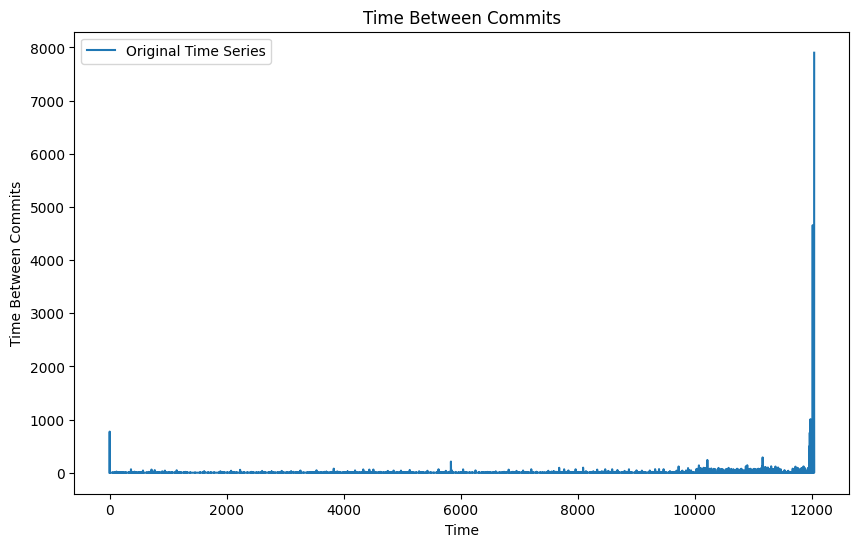

In [288]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(repo['time_between_commits'], label='Original Time Series')
plt.title('Time Between Commits')
plt.xlabel('Time')
plt.ylabel('Time Between Commits')
plt.legend()
plt.show()


In [289]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

check_stationarity(repo['time_between_commits'])


Results of Dickey-Fuller Test:
Test Statistic                    20.379823
p-value                            1.000000
#Lags Used                        40.000000
Number of Observations Used    12003.000000
Critical Value (1%)               -3.430895
Critical Value (5%)               -2.861781
Critical Value (10%)              -2.566898
dtype: float64


#### Apply Differencing

In [290]:
repo['diff_time_between_commits'] = repo['time_between_commits'].diff().dropna()

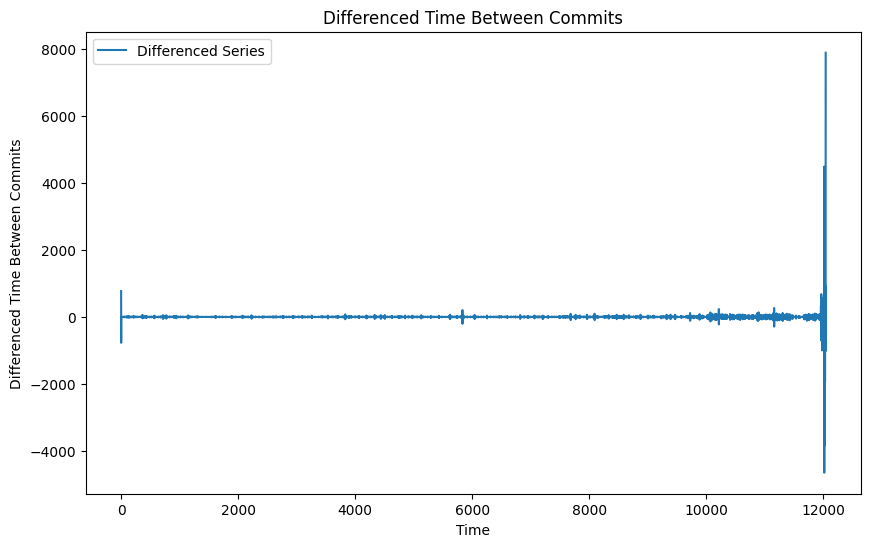

In [291]:
plt.figure(figsize=(10, 6))
plt.plot(repo['diff_time_between_commits'], label='Differenced Series')
plt.title('Differenced Time Between Commits')
plt.xlabel('Time')
plt.ylabel('Differenced Time Between Commits')
plt.legend()
plt.show()


#### Step 4: Fit the AR1 Model 

In [292]:
#Step 4: Fit the AR(1) Model

from statsmodels.tsa.ar_model import AutoReg

# Choose the right series based on the stationarity test
series_to_model = repo['diff_time_between_commits']

# Remove any NaN values that might have been introduced by differencing
series_to_model = series_to_model.dropna()

model = AutoReg(series_to_model, lags=1)
model_fitted = model.fit()


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [293]:
# Forecast the next value
forecast = model_fitted.predict(start=len(series_to_model), end=len(series_to_model))
print(forecast)


12043   -3938.462606
dtype: float64


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


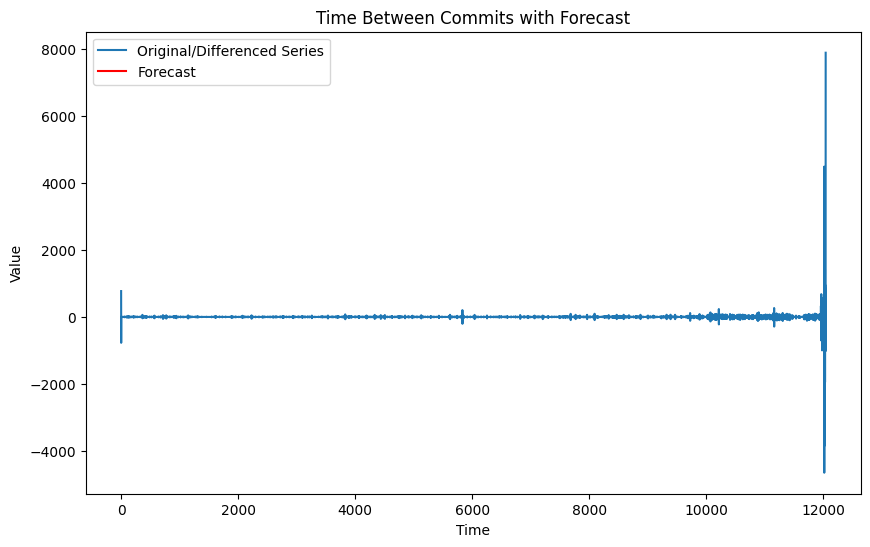

In [294]:
forecast_series = pd.Series(forecast, index=[len(series_to_model) + i for i in range(len(forecast))])

# Plot original or differenced series with forecast
plt.figure(figsize=(10, 6))
plt.plot(series_to_model, label='Original/Differenced Series')
plt.plot(forecast_series, 'r', label='Forecast')
plt.title('Time Between Commits with Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [295]:
# Model summary
print(model_fitted.summary())

# Check residuals
residuals = model_fitted.resid
print('Residuals mean:', residuals.mean())


                                AutoReg Model Results                                
Dep. Variable:     diff_time_between_commits   No. Observations:                12043
Model:                            AutoReg(1)   Log Likelihood              -72963.966
Method:                      Conditional MLE   S.D. of innovations            103.564
Date:                       Tue, 13 Feb 2024   AIC                         145933.933
Time:                               13:21:50   BIC                         145956.121
Sample:                                    1   HQIC                        145941.374
                                       12043                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.5920      0.944      0.627      0.530      -1.258       2.442
diff_time_between_com

In [296]:
#method 2 

#### stationary test and differenceing

In [297]:
from statsmodels.tsa.stattools import adfuller

# Conducting Augmented Dickey-Fuller test to check for stationarity
adf_result = adfuller(repo['time_between_commits'])

# Extracting the test statistic and p-value
adf_statistic, p_value = adf_result[0], adf_result[1]


adf_statistic, p_value


(20.379823400226385, 1.0)

In [298]:
# Differencing the data
df_diff = repo['time_between_commits'].diff().dropna()

# Conducting the ADF test again on the differenced data
adf_result_diff = adfuller(df_diff)

# Extracting the test statistic and p-value for the differenced data
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]

adf_statistic_diff, p_value_diff


(-7.051772661810239, 5.50297806874621e-10)

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

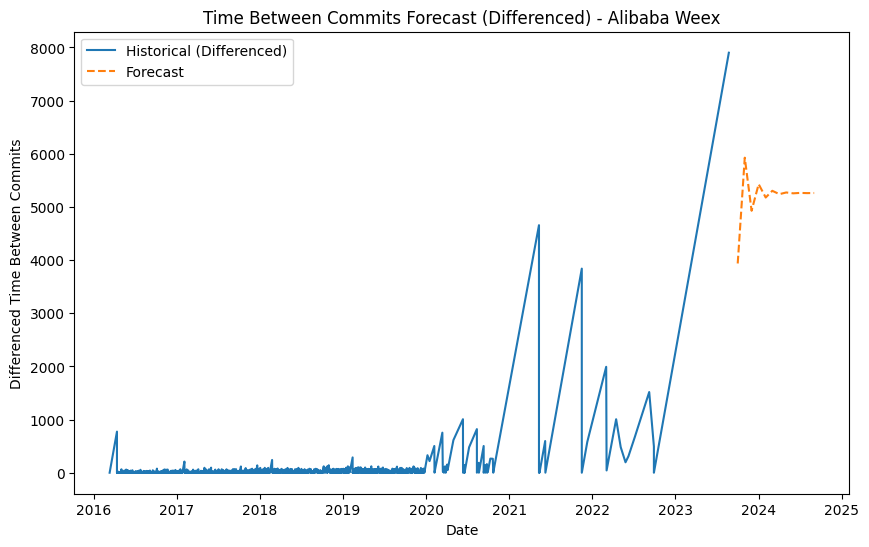

In [299]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)

model_diff = ARIMA(repo['time_between_commits'], order=(1, 1, 0))
model_fit_diff = model_diff.fit()

forecast_diff = model_fit_diff.forecast(steps=12)

# Find the last date in the historical data
last_date = repo.index[-1]

# Create a new date range for the forecast that continues from the last date, using 'MS' for month start
forecast_dates = pd.date_range(start=last_date, periods=len(forecast_diff)+1, freq='MS')[1:]

plt.figure(figsize=(10, 6))
plt.plot(repo.index, repo['time_between_commits'], label='Historical (Differenced)')
plt.plot(forecast_dates, forecast_diff, label='Forecast', linestyle='--')
plt.title('Time Between Commits Forecast (Differenced) - Alibaba Weex')
plt.xlabel('Date')
plt.ylabel('Differenced Time Between Commits')
plt.legend()
plt.show()


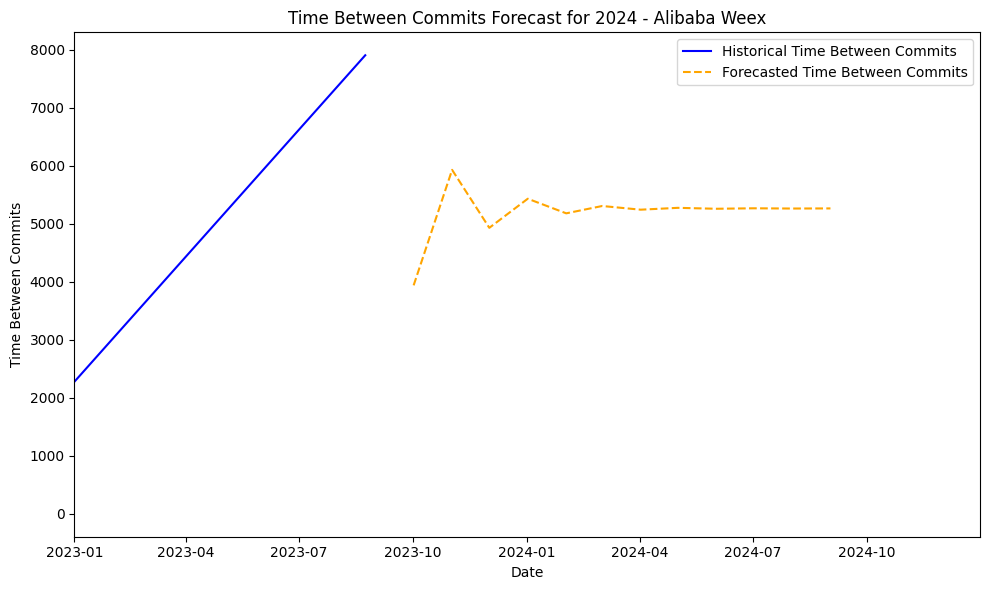

In [300]:
plt.figure(figsize=(10, 6))
plt.plot(repo.index, repo['time_between_commits'], label='Historical Time Between Commits', color='blue')
# Forecast data: using a dashed orange line
plt.plot(forecast_dates, forecast_diff, label='Forecasted Time Between Commits', color='orange', linestyle='--')

# Formatting the plot to be similar to the provided graph
plt.title('Time Between Commits Forecast for 2024 - Alibaba Weex')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.legend()

plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))

plt.tight_layout()
plt.show()

In [301]:
forecast_diff

12044    3936.314372
12045    5926.261902
12046    4927.435222
12047    5428.782479
12048    5177.138148
12049    5303.447544
12050    5240.048287
12051    5271.870669
12052    5255.897864
12053    5263.915193
12054    5259.891005
12055    5261.910890
Name: predicted_mean, dtype: float64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

data = {
    "date": pd.date_range(start="2016-03-11", periods=5, freq='D'),
    "time_between_commits": [0.0, 773.051667, 0.0, 0.020278, 0.626389]
}
df = pd.DataFrame(data)
df.set_index("date", inplace=True)



# We will fit an ARIMA model with parameters (p=1, d=0, q=0) -  an AR(1) model

model = ARIMA(df['time_between_commits'], order=(1, 0, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=5)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['time_between_commits'], label='Historical')
plt.plot(pd.date_range(start=df.index[-1], periods=6, freq='D')[1:], forecast, label='Forecast', linestyle='--')
plt.title('Time Between Commits Forecast')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.legend()
plt.show()


In [109]:
df.head(1)

,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,code_churn,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits,diff_time_between_commits
0,2016-03,https://api.github.com/repos/alibaba/weex/comm...,weex,lvscar,2016-03-11 10:18:12+00:00,203,0,203,Initial commit,2,0,"[('LICENSE', 'added', 201, 0, 201, 'https://gi...",203,1,1,203,0,0.0,NaN


In [60]:
df['date'] = pd.to_datetime(df['date'])   
df.set_index('date', inplace=True)   
time_series = df['time_between_commits']   


In [ ]:
plt.figure(figsize=(14, 7))
 
plt.plot(time_series.index, time_series, label='Original Series')
 
plt.plot(time_series_diff.index, time_series_diff, label='Differenced Series', alpha=0.7)

plt.plot(forecasts_df.index, forecasts_df['Forecast'], label='Forecasts', color='red')

plt.legend()
plt.title('Time Series Analysis with Forecasts')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.show()


In [58]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

time_series = df['time_between_commits']

# Step 2: Stationarity Check
result = adfuller(time_series.dropna())   
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Differencing the series
time_series_diff = time_series.diff().dropna()  

# Re-check stationarity with ADF test
result_diff = adfuller(time_series_diff)
print('ADF Statistic (Differenced Series): %f' % result_diff[0])
print('p-value (Differenced Series): %f' % result_diff[1])


# Assuming the differenced series is stationary
model_diff = AutoReg(time_series_diff, lags=1)
model_diff_fitted = model_diff.fit()

 
forecasts_diff = model_diff_fitted.predict(start=len(time_series_diff), end=len(time_series_diff)+5, dynamic=False)


last_observed_value = time_series.iloc[-1]
forecasts_original_scale = last_observed_value + forecasts_diff.cumsum()

print(forecasts_original_scale)




ADF Statistic: 20.379823
p-value: 1.000000
ADF Statistic (Differenced Series): -7.051773
p-value (Differenced Series): 0.000000


In [ ]:
model = AutoReg(time_series, lags=1)
model_fitted = model.fit()

# Step 5: Forecasting
forecasts = model_fitted.predict(start=len(time_series), end=len(time_series)+5, dynamic=False)

print(forecasts)


In [68]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
dates = pd.date_range(start='2016-01-01', periods=60, freq='M')  # 5 years of monthly data
health_scores = np.abs(np.random.normal(loc=0.6, scale=0.1, size=len(dates)))  # Simulated health scores

# Ensure the date column is the index
df.set_index('date', inplace=True)

adf_result = adfuller(df['time_between_commits'])

adf_result


(20.389909908186308,
 1.0,
 40,
 12003,
 {'1%': -3.430894922022415,
  '5%': -2.861780827545036,
  '10%': -2.5668981874552053},
 124423.73112558664)

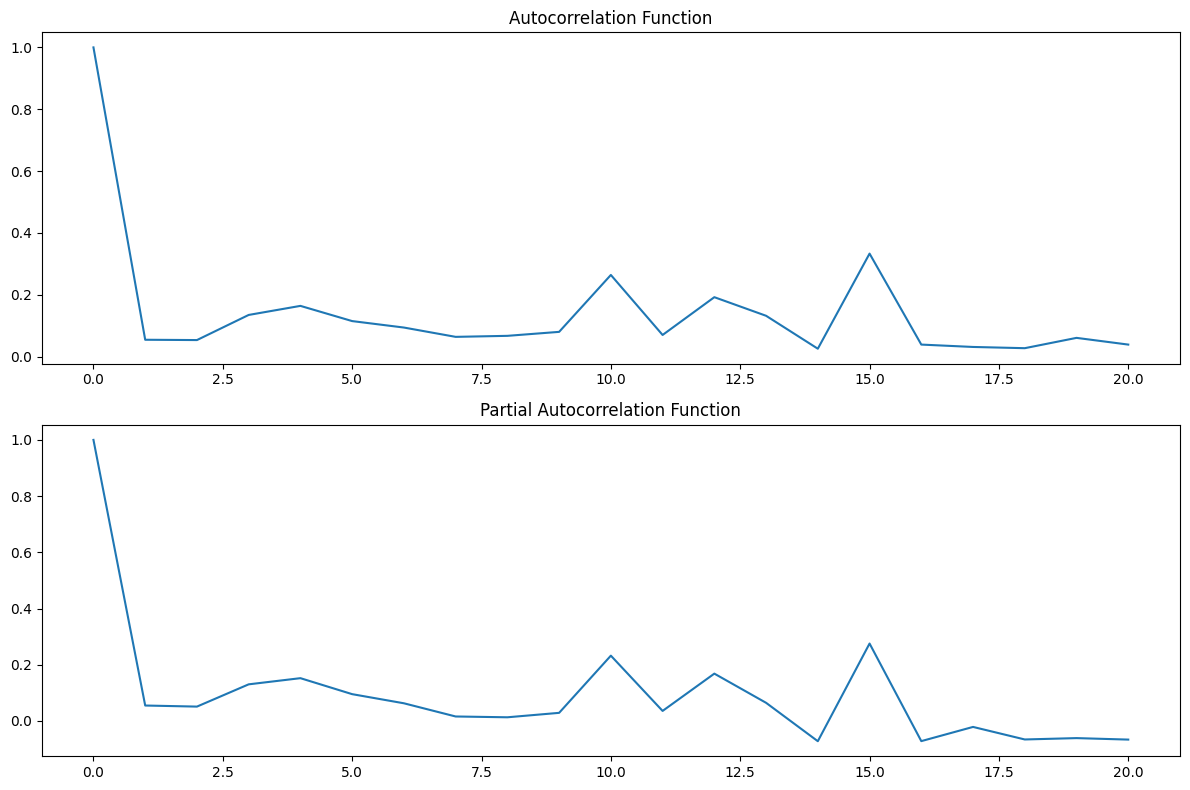

In [69]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
acf_plot = acf(df['time_between_commits'], nlags=20, fft=True)
ax1.plot(acf_plot)
ax1.set_title('Autocorrelation Function')

# PACF
pacf_plot = pacf(df['time_between_commits'], nlags=20, method='ywm')
ax2.plot(pacf_plot)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


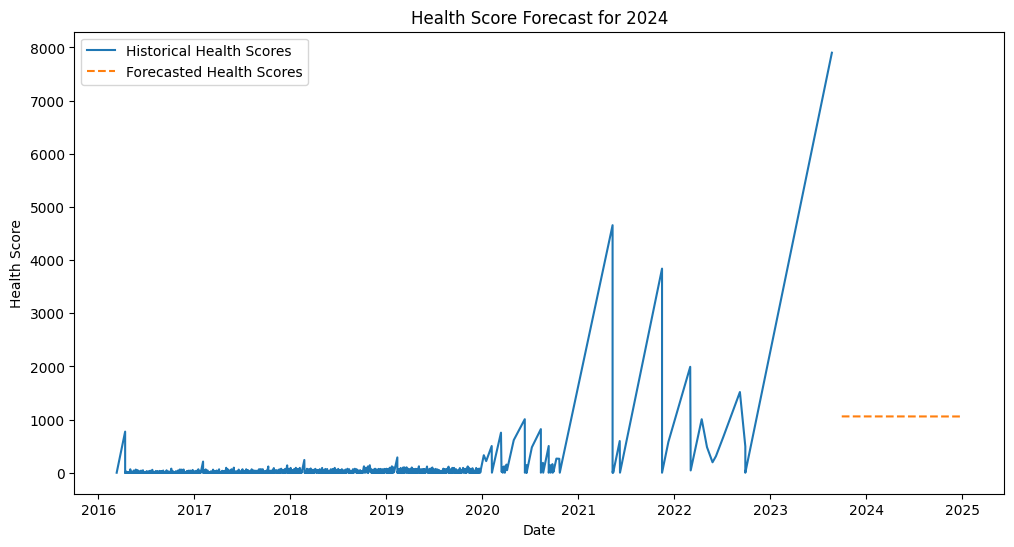

2023-09-30    1059.335357
2023-10-31    1059.249872
2023-11-30    1059.164393
2023-12-31    1059.078922
2024-01-31    1058.993457
2024-02-29    1058.907999
2024-03-31    1058.822549
2024-04-30    1058.737105
2024-05-31    1058.651668
2024-06-30    1058.566238
2024-07-31    1058.480815
2024-08-31    1058.395399
2024-09-30    1058.309990
2024-10-31    1058.224588
2024-11-30    1058.139193
2024-12-31    1058.053805
Freq: M, dtype: float64

In [70]:
model = ARIMA(df['time_between_commits'], order=(1, 0, 1))
model_fit = model.fit()

forecast_start_date = '2023-09-01'
forecast_end_date = '2024-12-31'

# Calculate the number of months between the last data point and December 2024
last_data_point_date = pd.to_datetime('2023-08-31')   
forecast_end_date = pd.to_datetime(forecast_end_date)

months_to_forecast = (forecast_end_date.year - last_data_point_date.year) * 12 + forecast_end_date.month - last_data_point_date.month

# Forecast the health scores from September 2023 to December 2024
forecast = model_fit.forecast(steps=months_to_forecast)

# Generate dates for the forecast period
forecast_dates = pd.date_range(start=last_data_point_date + pd.offsets.MonthBegin(1), periods=months_to_forecast, freq='M')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['time_between_commits'], label='Historical Health Scores')
plt.plot(forecast_dates, forecast, label='Forecasted Health Scores', linestyle='--')
plt.title('Health Score Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Health Score')
plt.legend()
plt.show()

forecast_2024 = pd.Series(forecast.values, index=forecast_dates)
forecast_2024
